In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

path = os.getcwd()
# Load and preprocess data
df = pd.read_excel(path + "/Native_Load_2024.xlsx")

# Drop na rows
df.dropna(inplace=True)

# Clean and convert datetime
df['Hour Ending'] = (df['Hour Ending']
                    .str.replace(' 24:00', ' 00:00')
                    .str.replace(' DST', ''))
df['Hour Ending'] = pd.to_datetime(df['Hour Ending'], format='%m/%d/%Y %H:%M')
df.set_index('Hour Ending', inplace=True)
load_series = df['ERCOT'].astype(float)

# Feature engineering
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['dayofyear'] = df.index.dayofyear

# Split data into 2023 and 2024
df_2024 = df[df.index.year == 2024]
df_2025 = df[df.index.year == 2025]

# Normalize data using only 2023 data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df_2024[['ERCOT', 'hour', 'dayofweek']])

# Transform all data
scaled_data_all = scaler.transform(df[['ERCOT', 'hour', 'dayofweek']])

# Create sequences with 168-hour (7-day) lookback and 24-hour forecast
def create_sequences(data, lookback, forecast_horizon):
    X, y = [], []
    for i in range(len(data)-lookback-forecast_horizon):
        X.append(data[i:(i+lookback)])
        y.append(data[(i+lookback):(i+lookback+forecast_horizon), 0])
    return np.array(X), np.array(y)

LOOKBACK = 168  # 7 days of hourly data
FORECAST = 24   # Predict next 24 hours

# Use 2023 data for training and validation
scaled_data_2024 = scaler.transform(df_2024[['ERCOT', 'hour', 'dayofweek']])
X, y = create_sequences(scaled_data_2024, LOOKBACK, FORECAST)

# Split dataset for training and validation
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Build LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(LOOKBACK, X.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(BatchNormalization())
model.add(Dense(FORECAST))
optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.summary()

# Train model
history = model.fit(X_train, y_train, 
                   epochs=25, 
                   batch_size=32,
                   validation_data=(X_val, y_val),
                   callbacks=[early_stopping],
                   verbose=1)

# Function for recursive multi-step forecasting
def forecast_future(model, last_sequence, future_steps):
    forecasts = []
    current_sequence = last_sequence.copy()
    
    for _ in range(future_steps // FORECAST + 1):
        # Ensure current_sequence has the correct shape
        if current_sequence.shape != (LOOKBACK, X.shape[2]):
            current_sequence = current_sequence[-LOOKBACK:]
        
        # Predict next FORECAST hours
        pred = model.predict(current_sequence.reshape(1, LOOKBACK, X.shape[2]))[0]
        forecasts.extend(pred)
        
        # Update sequence with prediction
        for i in range(min(FORECAST, future_steps - len(forecasts))):
            new_entry = np.zeros((1, X.shape[2]))
            new_entry[0,0] = pred[i]  # ERCOT value
            
            # Calculate new hour and day of week
            hours_ahead = i + 1
            current_hour = (current_sequence[-1,1] + hours_ahead) % 24
            current_day = (current_sequence[-1,2] + (hours_ahead / 24)) % 7
            
            new_entry[0,1] = current_hour  # Update hour
            new_entry[0,2] = current_day   # Update dayofweek
            
            current_sequence = np.vstack([current_sequence[1:], new_entry])
    
    return forecasts[:future_steps]

# 1. Predict 2024 data
predictions_2024 = []
# We'll predict 2024 in chunks of 30 days to avoid accumulating too much error
chunk_size = 24 * 30  # 30 days
total_hours_2024 = len(df_2024)

for start_idx in range(0, total_hours_2024, chunk_size):
    # Get the last known sequence from 2023 or previous predictions
    if start_idx == 0:
        # For the first chunk, use the last part of 2023 data
        last_known = scaled_data_2024[-LOOKBACK:]
    else:
        # For subsequent chunks, use the last LOOKBACK hours of actual and predicted data
        end_idx = min(start_idx, total_hours_2024)
        actual_data = scaler.transform(df[['ERCOT', 'hour', 'dayofweek']].iloc[-(LOOKBACK+end_idx):-end_idx])
        last_known = actual_data
    
    # Predict the next chunk
    forecast_steps = min(chunk_size, total_hours_2024 - start_idx)
    chunk_forecast = forecast_future(model, last_known, forecast_steps)
    predictions_2024.extend(chunk_forecast[:forecast_steps])

# 2. Predict first 30 days of 2025
# Use the last LOOKBACK hours of 2024 data
last_known_2024 = scaler.transform(df_2024.iloc[-LOOKBACK:][['ERCOT', 'hour', 'dayofweek']].values)
forecast_steps_2025 = 24 * 30  # 30 days
predictions_2025 = forecast_future(model, last_known_2024, forecast_steps_2025)

# Inverse transform predictions
def prepare_for_inverse_transform(predictions):
    forecast_array = np.zeros((len(predictions), 3))
    forecast_array[:,0] = predictions
    return forecast_array

# Transform 2024 predictions back to original scale
predictions_2024_array = prepare_for_inverse_transform(predictions_2024)
predictions_2024_ercot = scaler.inverse_transform(predictions_2024_array)[:,0]

# Transform 2025 predictions back to original scale
predictions_2025_array = prepare_for_inverse_transform(predictions_2025)
predictions_2025_ercot = scaler.inverse_transform(predictions_2025_array)[:,0]

# Create date ranges for forecasts
forecast_dates_2024 = df_2024.index
forecast_dates_2025 = pd.date_range(start='2025-01-01',
                                   periods=len(predictions_2025_ercot),
                                   freq='H')

# Calculate metrics for 2024 predictions
mse_2024 = mean_squared_error(df_2024['ERCOT'], predictions_2024_ercot)
mae_2024 = mean_absolute_error(df_2024['ERCOT'], predictions_2024_ercot)
r2_2024 = r2_score(df_2024['ERCOT'], predictions_2024_ercot)

print(f"2024 Predictions Metrics:")
print(f"Mean Squared Error (MSE): {mse_2024:.2f}")
print(f"Mean Absolute Error (MAE): {mae_2024:.2f}")
print(f"R² Score: {r2_2024:.4f}")

# Plot 2024 results
plt.figure(figsize=(16,8))
plt.plot(df_2024.index, df_2024['ERCOT'], label='Actual 2024 Load', color='blue')
plt.plot(forecast_dates_2024, predictions_2024_ercot, label='LSTM Forecast 2024', color='red', alpha=0.7)
plt.title('ERCOT Load Forecast vs Actual for 2024')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2025 forecast
plt.figure(figsize=(16,8))
plt.plot(forecast_dates_2025, predictions_2025_ercot, label='LSTM Forecast 2025', color='green')
plt.title('ERCOT Load 30-Day Forecast for January 2025')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot both 2024 December and 2025 January to see the transition
# Get December 2024 data
dec_2024_mask = (df_2024.index >= '2024-12-01')
dec_2024 = df_2024[dec_2024_mask]
dec_2024_pred = predictions_2024_ercot[-len(dec_2024):]

plt.figure(figsize=(16,8))
plt.plot(dec_2024.index, dec_2024['ERCOT'], label='Actual Dec 2024', color='blue')
plt.plot(dec_2024.index, dec_2024_pred, label='Forecast Dec 2024', color='red', alpha=0.7)
plt.plot(forecast_dates_2025, predictions_2025_ercot, label='Forecast Jan 2025', color='green', alpha=0.7)
plt.title('ERCOT Load Forecast: December 2024 to January 2025')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 168, 100)       │        41,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 168, 100)       │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 168, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 168, 100)       │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 168, 100)       │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 168, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 24)             │         1,224 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,424 (603.22 KB)

 Trainable params: 153,924 (601.27 KB)

 Non-trainable params: 500 (1.95 KB)

Epoch 1/25
215/215 ━━━━━━━━━━━━━━━━━━━━ 30s 132ms/step - loss: 0.6020 - val_loss: 0.0670
Epoch 2/25
215/215 ━━━━━━━━━━━━━━━━━━━━ 28s 129ms/step - loss: 0.1955 - val_loss: 0.0863
Epoch 3/25
215/215 ━━━━━━━━━━━━━━━━━━━━ 29s 136ms/step - loss: 0.1354 - val_loss: 0.0771
Epoch 4/25
215/215 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - loss: 0.0997 - val_loss: 0.0530
Epoch 5/25
215/215 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - loss: 0.0724 - val_loss: 0.0361
Epoch 6/25
215/215 ━━━━━━━━━━━━━━━━━━━━ 29s 136ms/step - loss: 0.0534 - val_loss: 0.0236
Epoch 7/25
215/215 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - loss: 0.0407 - val_loss: 0.0173
Epoch 8/25
215/215 ━━━━━━━━━━━━━━━━━━━━ 28s 131ms/step - loss: 0.0323 - val_loss: 0.0136
Epoch 9/25
215/215 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - loss: 0.0273 - val_loss: 0.0097
Epoch 10/25
215/215 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - loss: 0.0240 - val_loss: 0.0087
Epoch 11/25
215/215 ━━━━━━━━━━━━━━━━━━━━ 29s 136ms/step - loss: 0.0213 - val_loss: 0.0080
Epoch 12/25
215/215

ValueError: cannot reshape array of size 432 into shape (1,168,newaxis)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 168, 100)       │        41,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 168, 100)       │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 168, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 168, 100)       │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 168, 100)       │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 168, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 24)             │         1,224 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,424 (603.22 KB)

 Trainable params: 153,924 (601.27 KB)

 Non-trainable params: 500 (1.95 KB)

Epoch 1/25
171/171 ━━━━━━━━━━━━━━━━━━━━ 24s 131ms/step - loss: 0.7224 - val_loss: 0.2009
Epoch 2/25
171/171 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - loss: 0.2167 - val_loss: 0.1603
Epoch 3/25
171/171 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - loss: 0.1545 - val_loss: 0.1031
Epoch 4/25
171/171 ━━━━━━━━━━━━━━━━━━━━ 23s 132ms/step - loss: 0.1168 - val_loss: 0.0732
Epoch 5/25
171/171 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - loss: 0.0908 - val_loss: 0.0542
Epoch 6/25
171/171 ━━━━━━━━━━━━━━━━━━━━ 24s 137ms/step - loss: 0.0701 - val_loss: 0.0370
Epoch 7/25
171/171 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - loss: 0.0547 - val_loss: 0.0290
Epoch 8/25
171/171 ━━━━━━━━━━━━━━━━━━━━ 23s 135ms/step - loss: 0.0435 - val_loss: 0.0218
Epoch 9/25
171/171 ━━━━━━━━━━━━━━━━━━━━ 23s 137ms/step - loss: 0.0356 - val_loss: 0.0180
Epoch 10/25
171/171 ━━━━━━━━━━━━━━━━━━━━ 23s 137ms/step - loss: 0.0309 - val_loss: 0.0162
Epoch 11/25
171/171 ━━━━━━━━━━━━━━━━━━━━ 23s 133ms/step - loss: 0.0272 - val_loss: 0.0137
Epoch 12/25
171/171

/var/folders/dh/j5bmpt9d6clgh4sxgj75h9zh0000gn/T/ipykernel_37164/1922114756.py:160: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_dates_2025 = pd.date_range(start='2025-01-01',


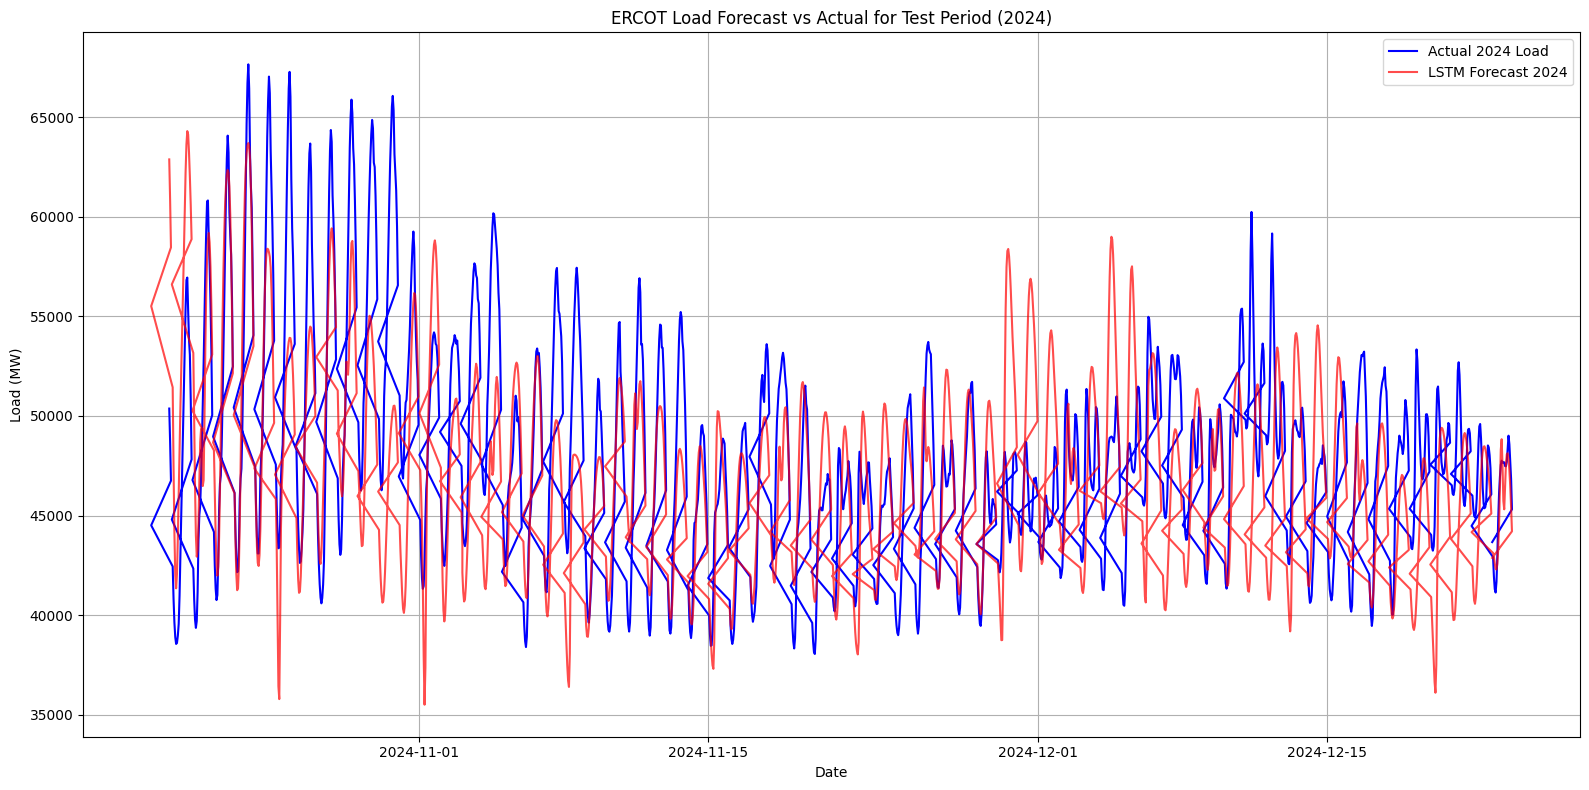

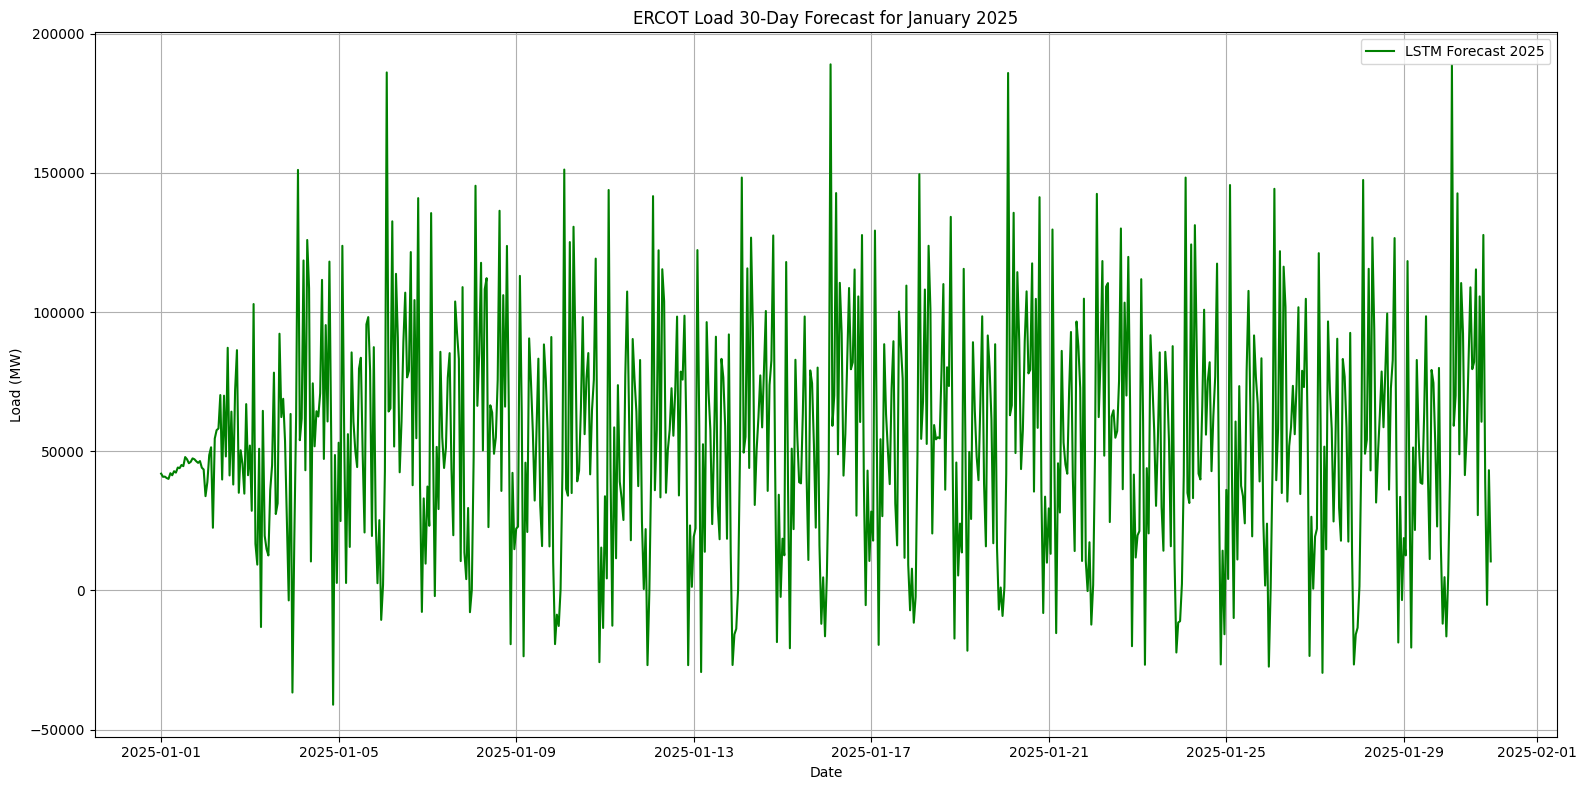

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

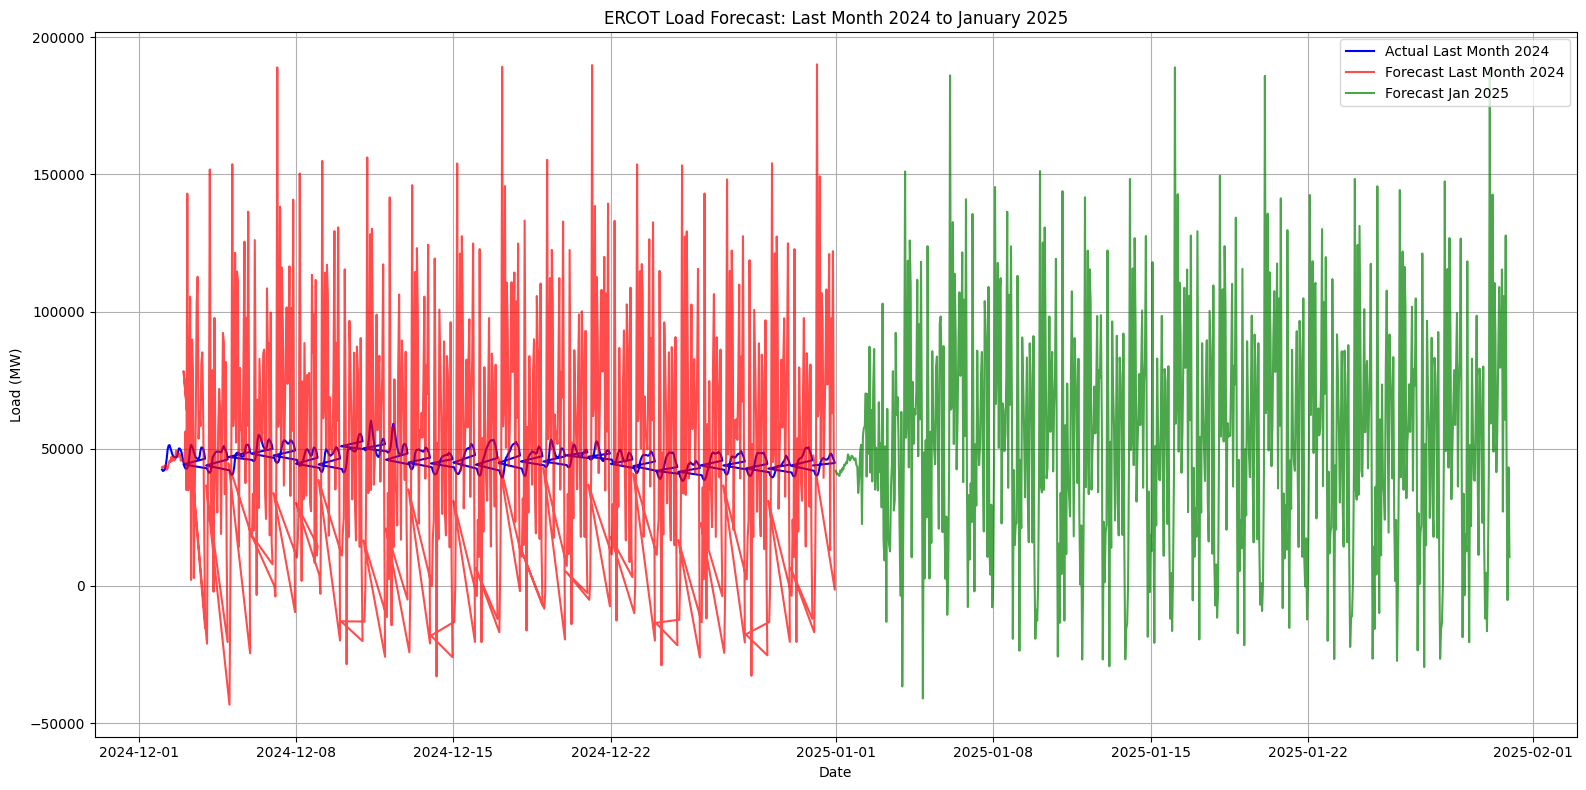

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

path = os.getcwd()
# Load and preprocess data
df = pd.read_excel(path + "/Native_Load_2024.xlsx")

# Drop na rows
df.dropna(inplace=True)

# Clean and convert datetime
df['Hour Ending'] = (df['Hour Ending']
                    .str.replace(' 24:00', ' 00:00')
                    .str.replace(' DST', ''))
df['Hour Ending'] = pd.to_datetime(df['Hour Ending'], format='%m/%d/%Y %H:%M')
df.set_index('Hour Ending', inplace=True)
load_series = df['ERCOT'].astype(float)

# Feature engineering
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['dayofyear'] = df.index.dayofyear

# Split data into training and testing portions (first 80% for training, last 20% for testing)
train_size = int(len(df) * 0.8)
df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df_train[['ERCOT', 'hour', 'dayofweek']])

# Transform all data
scaled_data_train = scaler.transform(df_train[['ERCOT', 'hour', 'dayofweek']])
scaled_data_test = scaler.transform(df_test[['ERCOT', 'hour', 'dayofweek']])
scaled_data_all = scaler.transform(df[['ERCOT', 'hour', 'dayofweek']])

# Create sequences with 168-hour (7-day) lookback and 24-hour forecast
def create_sequences(data, lookback, forecast_horizon):
    X, y = [], []
    for i in range(len(data)-lookback-forecast_horizon):
        X.append(data[i:(i+lookback)])
        y.append(data[(i+lookback):(i+lookback+forecast_horizon), 0])
    return np.array(X), np.array(y)

LOOKBACK = 168  # 7 days of hourly data
FORECAST = 24   # Predict next 24 hours

# Create sequences for training data
X_train, y_train = create_sequences(scaled_data_train, LOOKBACK, FORECAST)

# Split training data for validation
val_size = int(len(X_train) * 0.2)
X_val = X_train[-val_size:]
y_val = y_train[-val_size:]
X_train = X_train[:-val_size]
y_train = y_train[:-val_size]

# Build LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(LOOKBACK, X_train.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(BatchNormalization())
model.add(Dense(FORECAST))
optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.summary()

# Train model
history = model.fit(X_train, y_train, 
                   epochs=25, 
                   batch_size=32,
                   validation_data=(X_val, y_val),
                   callbacks=[early_stopping],
                   verbose=1)

# Function for recursive multi-step forecasting
def forecast_future(model, last_sequence, future_steps):
    forecasts = []
    current_sequence = last_sequence.copy()
    
    for _ in range(future_steps // FORECAST + 1):
        # Predict next FORECAST hours
        pred = model.predict(current_sequence.reshape(1, LOOKBACK, -1))[0]
        forecasts.extend(pred)
        
        # Update sequence with prediction
        for i in range(min(FORECAST, future_steps - len(forecasts))):
            new_entry = np.zeros((1, X_train.shape[2]))
            new_entry[0,0] = pred[i]  # ERCOT value
            
            # Calculate new hour and day of week
            hours_ahead = i + 1
            current_hour = (current_sequence[-1,1] + hours_ahead) % 24
            current_day = (current_sequence[-1,2] + (hours_ahead / 24)) % 7
            
            new_entry[0,1] = current_hour  # Update hour
            new_entry[0,2] = current_day   # Update dayofweek
            
            current_sequence = np.vstack([current_sequence[1:], new_entry])
    
    return forecasts[:future_steps]

# 1. Predict test data (last 20% of 2024)
# Create sequences for test data
X_test, y_test = create_sequences(scaled_data_test, LOOKBACK, FORECAST)

# Make predictions on test data
test_predictions = []
for i in range(len(X_test)):
    pred = model.predict(X_test[i:i+1])[0]
    test_predictions.extend(pred[:1])  # Take only the first prediction to avoid overlap

# Prepare test predictions for inverse transform
test_pred_array = np.zeros((len(test_predictions), 3))
test_pred_array[:,0] = test_predictions
test_pred_ercot = scaler.inverse_transform(test_pred_array)[:,0]

# Calculate metrics for test predictions
test_actual = df_test['ERCOT'].values[:len(test_pred_ercot)]
mse_test = mean_squared_error(test_actual, test_pred_ercot)
mae_test = mean_absolute_error(test_actual, test_pred_ercot)
r2_test = r2_score(test_actual, test_pred_ercot)

print(f"Test Data Metrics:")
print(f"Mean Squared Error (MSE): {mse_test:.2f}")
print(f"Mean Absolute Error (MAE): {mae_test:.2f}")
print(f"R² Score: {r2_test:.4f}")

# 2. Predict first 30 days of 2025
# Use the last LOOKBACK hours of 2024 data
last_known = scaled_data_all[-LOOKBACK:]
forecast_steps_2025 = 24 * 30  # 30 days
predictions_2025 = forecast_future(model, last_known, forecast_steps_2025)

# Transform 2025 predictions back to original scale
predictions_2025_array = np.zeros((len(predictions_2025), 3))
predictions_2025_array[:,0] = predictions_2025
predictions_2025_ercot = scaler.inverse_transform(predictions_2025_array)[:,0]

# Create date ranges for forecasts
forecast_dates_2025 = pd.date_range(start='2025-01-01',
                                   periods=len(predictions_2025_ercot),
                                   freq='H')

# Plot test results
plt.figure(figsize=(16,8))
plt.plot(df_test.index[:len(test_pred_ercot)], test_actual, label='Actual 2024 Load', color='blue')
plt.plot(df_test.index[:len(test_pred_ercot)], test_pred_ercot, label='LSTM Forecast 2024', color='red', alpha=0.7)
plt.title('ERCOT Load Forecast vs Actual for Test Period (2024)')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2025 forecast
plt.figure(figsize=(16,8))
plt.plot(forecast_dates_2025, predictions_2025_ercot, label='LSTM Forecast 2025', color='green')
plt.title('ERCOT Load 30-Day Forecast for January 2025')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot both December 2024 and January 2025 to see the transition
# Get December 2024 data (or last month of available data)
last_month_mask = (df.index >= df.index[-30*24])
last_month_data = df[last_month_mask]

# Make predictions for the last month of 2024
last_month_sequence = scaled_data_all[-(LOOKBACK + len(last_month_data)):-len(last_month_data)]
last_month_pred = forecast_future(model, last_month_sequence, len(last_month_data))
last_month_pred_array = np.zeros((len(last_month_pred), 3))
last_month_pred_array[:,0] = last_month_pred
last_month_pred_ercot = scaler.inverse_transform(last_month_pred_array)[:,0]

plt.figure(figsize=(16,8))
plt.plot(last_month_data.index, last_month_data['ERCOT'], label='Actual Last Month 2024', color='blue')
plt.plot(last_month_data.index, last_month_pred_ercot, label='Forecast Last Month 2024', color='red', alpha=0.7)
plt.plot(forecast_dates_2025, predictions_2025_ercot, label='Forecast Jan 2025', color='green', alpha=0.7)
plt.title('ERCOT Load Forecast: Last Month 2024 to January 2025')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
path = os.getcwd()
# Load and preprocess data
df2 = pd.read_excel(path + "/Native_Load_2025.xlsx")

# Drop na rows
df2.dropna(inplace=True)

# Clean and convert datetime
df2['Hour Ending'] = (df2['Hour Ending']
                    .str.replace(' 24:00', ' 00:00')
                    .str.replace(' DST', ''))
df2['Hour Ending'] = pd.to_datetime(df2['Hour Ending'], format='%m/%d/%Y %H:%M')
df2.set_index('Hour Ending', inplace=True)
load_series = df2['ERCOT'].astype(float)

# Feature engineering
df2['hour'] = df2.index.hour
df2['dayofweek'] = df2.index.dayofweek
df2['dayofyear'] = df2.index.dayofyear

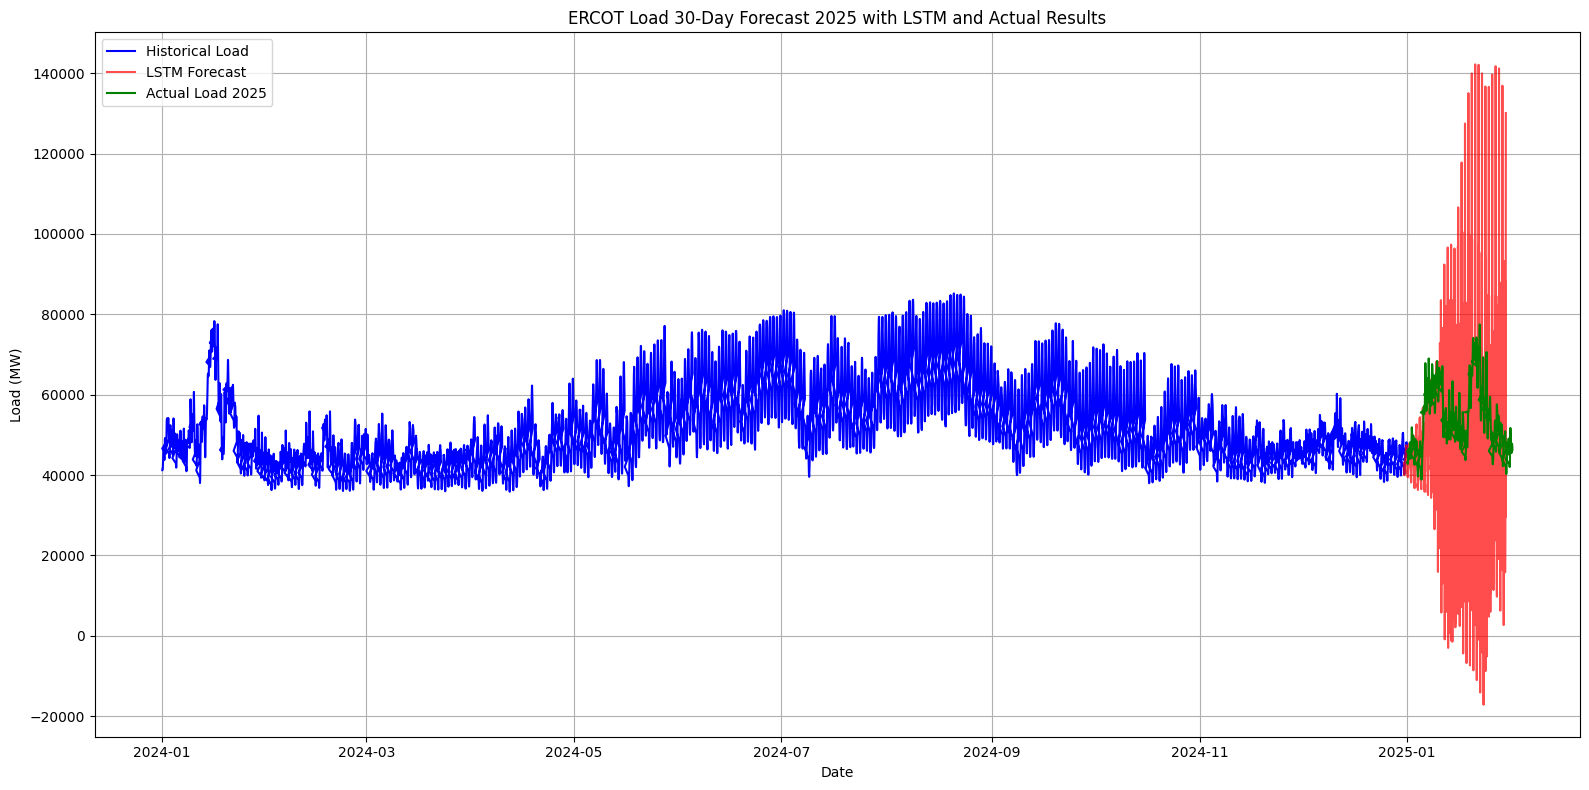

In [12]:
# Plot results
plt.figure(figsize=(16,8))
plt.plot(df.index, df['ERCOT'], label='Historical Load', color='blue')
plt.plot(forecast_dates, forecast_ercot, label='LSTM Forecast', color='red', alpha=0.7)
plt.plot(df2.index, df2['ERCOT'], label='Actual Load 2025', color='green')
plt.title('ERCOT Load 30-Day Forecast 2025 with LSTM and Actual Results')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

# Calculate confidence intervals (assuming a fixed percentage for simplicity)
confidence_interval = 0.1  # 10% confidence interval
forecast_upper = forecast_ercot * (1 + confidence_interval)
forecast_lower = forecast_ercot * (1 - confidence_interval)

# Create subplots
fig = make_subplots(rows=1, cols=1)

# Add historical load trace
fig.add_trace(go.Scatter(x=df.index, y=df['ERCOT'], mode='lines', name='Historical Load', line=dict(color='blue')), row=1, col=1)

# Add forecast trace
fig.add_trace(go.Scatter(x=forecast_dates, y=forecast_ercot, mode='lines', name='LSTM Forecast', line=dict(color='red', dash='dash')), row=1, col=1)

# Add confidence interval
fig.add_trace(go.Scatter(x=np.concatenate([forecast_dates, forecast_dates[::-1]]),
                         y=np.concatenate([forecast_upper, forecast_lower[::-1]]),
                         fill='toself',
                         fillcolor='rgba(255, 0, 0, 0.2)',
                         line=dict(color='rgba(255, 255, 255, 0)'),
                         hoverinfo="skip",
                         showlegend=False), row=1, col=1)

# Add actual results trace from df2
fig.add_trace(go.Scatter(x=df2.index, y=df2['ERCOT'], mode='lines', name='Actual Load 2025', line=dict(color='green')), row=1, col=1)

# Update layout
fig.update_layout(title='ERCOT Load 30-Day Forecast 2025 with LSTM and Actual Results',
                  xaxis_title='Date',
                  yaxis_title='Load (MW)',
                  legend=dict(x=0, y=1),
                  template='plotly_white')

# Show plot
fig.show()

# Save plot as HTML
fig.write_html("ercot_load_forecast_with_actual_results.html")